<a href="https://colab.research.google.com/github/zergswim/study/blob/main/2%EC%A1%B0_5%EC%A3%BC%EC%B0%A8_%EB%AF%B8%EC%85%98_%EC%A0%9C%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Q1.
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms

from torch.utils.data import DataLoader

#MNIST 데이터 다운로드
root = './data'
mnist_train = dset.MNIST(root=root, train=True, transform=transforms.ToTensor(), download=True) 
mnist_test = dset.MNIST(root=root, train=False, transform=transforms.ToTensor(), download=True)

#데이터 로더 정의
batch_size = 100
#train_loader = DataLoader(mnist_train, batch_size = batch_size)
#test_loader = DataLoader(mnist_test, batch_size = batch_size)
train_loader = DataLoader(mnist_train, batch_size = batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size = batch_size, shuffle=False, drop_last=True)

# for X, y in test_loader:
#     print("Shape of X [N(Batch size), C(Channel Size), H(2D Tensor Input Height), W(2D Tensor Input Width)]: ", X.shape)
#     print("Shape of y: ", y.shape, y.dtype)
#     break

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [2]:
#Q2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #GPU 사용여부체크

#단순 선형모델 (인식률 약 86%... epoch 많이 필요..)
# model = nn.Linear(784, 10, bias=True).to(device)
# torch.nn.init.normal_(model.weight) #초기화

#nn.Module 상속, 커스텀 모델 정의
class CustomModel(nn.Module):

    #다계층 선형모델 (인식률 약 96%)
    def __init__(self):
        super(CustomModel, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512), #입력 이미지 크기 28px*28px = 784
            nn.ReLU(), #비선형처리(ReLU)
            nn.Linear(512, 512), #중간레이어 지정
            nn.ReLU(), #비선형처리(ReLU)
            nn.Linear(512, 10) #출력 결과값 0~9까지 = 10
        )

    #학습범위 오버, CNN 모델도전 (인식률 약 99%)
    # def __init__(self):
    #     super(CustomModel, self).__init__()
    #     self.linear_relu_stack = nn.Sequential(
    #       nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
    #       nn.ReLU(),
    #       nn.MaxPool2d(kernel_size=2, stride=2),
    #       nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    #       nn.ReLU(),
    #       nn.MaxPool2d(kernel_size=2, stride=2),
    #       nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    #       nn.ReLU(),
    #       nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
    #       nn.Flatten(),
    #       nn.Linear(2048, 625, bias=True),
    #       nn.ReLU(),
    #       nn.Dropout(p=1 - 0.5),
    #       nn.Linear(625, 10, bias=True)
    #     )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = CustomModel().to(device)

In [3]:
#Q3
criterion = nn.CrossEntropyLoss().to(device) # cost function 정의
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) # SGD 방식, learning rate 지정

In [4]:
#Q4
training_epochs = 5

for epoch in range(training_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        imgs = imgs.view(-1, 28*28) #batch 단위 100개의 1차원,벡터로 변환?, (CNN 사용시 reshape 불필요)
        #imgs = imgs.reshape(-1, 28*28) 

        #모델에 이미지내용 입력
        outputs = model(imgs)

        #정답(labels)과 출력(예측)값의 error 계산
        loss = criterion(outputs, labels)  #criterion 에 정의된 Cross Entropy Error 방식

        # CEE - High Level 구현
        #loss = nn.functional.nll_loss(nn.functional.softmax(outputs, dim=1), labels) 

        # CEE - Low Level 구현
        # one_hot = torch.zeros_like(outputs.float()) #출력 shape 의 행렬정의
        # one_hot.scatter_(1, labels.unsqueeze(1), 1) #labels 를 one_hot 형태로 변형? 3 -> [0,0,0,1,0,0,0,0,0,0]
        # loss = (one_hot * -torch.log(nn.functional.softmax(outputs))).sum(dim=1).mean() 

        # Mean Square Error 방식은 다계층 모델에 매우 낮은 성능으로 판단
        # _,pred = torch.max(outputs, 1)
        # pred = torch.tensor(pred, device=device, dtype=torch.float32, requires_grad=True)
        # loss = torch.mean((pred - labels).float() ** 2)

        optimizer.zero_grad() 
        # gradients 왜 매번 초기화가 필요할까?, 결국, 학습된 데이터는 gradient 가 아니라 nn 값인가..

        loss.backward()    # gradients 계산(backpropagation)
        optimizer.step()   # gradients 업데이트

        _,pred = torch.max(outputs, 1) # 최대 출력값(예측)
        accuracy = (labels == pred).float().mean() #labels 와 비교해서 정확도 계산

        if (i+1) % 100 == 0:
          print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%"
          .format(epoch+1, training_epochs, i+1, len(train_loader), loss.item(), accuracy.item() * 100))

Epoch [1/5], Step [100/600], Loss: 0.7353, Accuracy: 80.00%
Epoch [1/5], Step [200/600], Loss: 0.4707, Accuracy: 84.00%
Epoch [1/5], Step [300/600], Loss: 0.4077, Accuracy: 85.00%
Epoch [1/5], Step [400/600], Loss: 0.3849, Accuracy: 91.00%
Epoch [1/5], Step [500/600], Loss: 0.2934, Accuracy: 90.00%
Epoch [1/5], Step [600/600], Loss: 0.3047, Accuracy: 91.00%
Epoch [2/5], Step [100/600], Loss: 0.2012, Accuracy: 94.00%
Epoch [2/5], Step [200/600], Loss: 0.2018, Accuracy: 91.00%
Epoch [2/5], Step [300/600], Loss: 0.1607, Accuracy: 94.00%
Epoch [2/5], Step [400/600], Loss: 0.1828, Accuracy: 96.00%
Epoch [2/5], Step [500/600], Loss: 0.2004, Accuracy: 95.00%
Epoch [2/5], Step [600/600], Loss: 0.2003, Accuracy: 96.00%
Epoch [3/5], Step [100/600], Loss: 0.1895, Accuracy: 95.00%
Epoch [3/5], Step [200/600], Loss: 0.0743, Accuracy: 99.00%
Epoch [3/5], Step [300/600], Loss: 0.1134, Accuracy: 94.00%
Epoch [3/5], Step [400/600], Loss: 0.1415, Accuracy: 96.00%
Epoch [3/5], Step [500/600], Loss: 0.183

Test accuracy for 10000 images : 97.09%
실제값: 3  예측값: 9


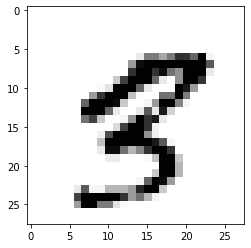

실제값: 5  예측값: 6


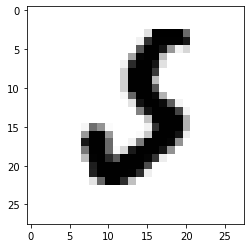

In [5]:
#Q5
model.eval()
# linear.eval()

with torch.no_grad():
  correct = 0
  total = 0
  for i, (imgs, labels) in enumerate(test_loader):
    imgs, labels = imgs.to(device), labels.to(device)
    imgs = imgs.view(-1, 28*28) #(CNN 사용시 reshape 불필요)

    outputs = model(imgs)

    pred = outputs.data.max(1)[1] # 최대 출력값(예측)
    #_,argmax = torch.max(outputs, 1)

    total += imgs.size(0)
    correct += (labels == pred).sum().item()

  print("Test accuracy for {} images : {:.2f}%".format(total, correct/total*100))

#마지막 배치에서 예측실패 이미지 체크 후 실제값과 비교
import matplotlib.pyplot as plt
for idx, notEq in enumerate((labels != pred)):
  if(notEq):
    print("실제값:", labels[idx].item(), " 예측값:", pred[idx].item())
    x = imgs[idx].view(28,28).cpu() #gpu 사용시, 왜 gpu 에 올라간 텐서는 numpy 변환이 안될까?
    plt.imshow(x,cmap="Greys", interpolation="nearest")
    plt.show()

Label:  0
Prediction:  0


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


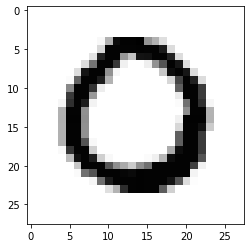

In [6]:
#MNIST 학습모델 샘플데이터 테스트
import matplotlib.pyplot as plt
import random

r = random.randint(0, len(mnist_test) - 1)
X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28*28).float().to(device)
#X_single_data = mnist_test.test_data[r:r + 1].float().to(device)
Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

print("Label: ", Y_single_data.item())
single_prediction = model(X_single_data)
#single_prediction = model(X_single_data.reshape(1,1,28,28))
#single_prediction = linear(X_single_data)
print("Prediction: ", torch.argmax(single_prediction,1).item())
plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28),cmap="Greys", interpolation="nearest")
plt.show()